<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Qtensor-vs-other-simulators:-speed" data-toc-modified-id="Qtensor-vs-other-simulators:-speed-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Qtensor vs other simulators: speed</a></span><ul class="toc-item"><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Read-data" data-toc-modified-id="Read-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read data</a></span></li><li><span><a href="#Plot-comparisons" data-toc-modified-id="Plot-comparisons-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plot comparisons</a></span></li><li><span><a href="#CLI" data-toc-modified-id="CLI-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>CLI</a></span></li></ul></li></ul></div>

# Qtensor vs other simulators: speed

The functions from this notebook are exported and invoken on a remote server.

The data that is generated is transferred back to local machine and plotted here as well

## Generate data

In [1]:
#export
import numpy as np
import qtensor
import quimb
import sys
import pyrofiler.c as profile
#sys.path.pop(2)

from qtensor.tests.qiskit_qaoa_energy import simulate_qiskit_amps
from qtensor.tests.qaoa_quimb import simulate_one_parallel as simulate_quimb_energy
from qtensor.tests.acqdp_qaoa import single_qaoa_query as simulate_acqdp_energy
import matplotlib.pyplot as plt
import time

from cartesian_explorer import Explorer, caches

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#export
cache = caches.JobLibCache('../../caex_cache/skylake_speed_comparison')
ex = Explorer(cache=cache)

In [4]:
#export    
@ex.provider
def graph(N, d=3, graph_type='random', seed=10):
    return qtensor.toolbox.random_graph(nodes=N, type=graph_type, degree=d, seed=seed)

In [24]:
#export
@ex.provider
def simulator(sim):
    simulators = qtensor.tools.benchmarking.simulators
    return {
        'qtensor': simulators.QtensorSimulator,
        'quimb': simulators.QuimbSimulator,
        'acqdp': simulators.AcqdpSimulator,
        'qiskit': simulators.QiskitSimulator
    }[sim]()

@ex.add_function(provides=('opts', 'energy_flops', 'energy_opt_time', 'energy_mem_est', 'energy_tws')
                 , requires=('graph', 'p', 'simulator')
                )
def energy_cost(graph, p,
                simulator,
                sim='qtensor',
                qtn_ordering_algo='greedy',
                qmb_max_repeats=10,
               ):
    kwargs = {}
    if sim=='qtensor':
        kwargs['ordering_algo'] = qtn_ordering_algo
    elif sim=='quimb':
        kwargs['max_repeats'] = qmb_max_repeats
    try:
        opts, ests, time = simulator.optimize_qaoa_energy(graph, p, **kwargs)
    except Exception as e:
        print('error', e)
        return None, None, None, None, None
    flops = [est.flops for est in ests]
    mems = [est.mems for est in ests]
    tws = [est.width for est in ests]
    print(flops)
    return opts, sum(flops), time, max(mems), tws
        

In [19]:
@ex.add_function(provides=('energy_time', 'energy_memory')
                 , requires=('graph', 'p', 'simulator', 'opts')
                )
def energy_cost(graph, p, simulator, opts,
                sim='qtensor',
                qtn_backend='einsum',
               ):
    kwargs = {}
    if sim=='qtensor':
        kwargs['backend'] = qtn_backend
        
    try:
        res, time, memory = simulator.simulate_qaoa_energy(graph, p, opts, **kwargs)
    except Exception as e:
        print('error', e)
        return None, None
    return time, memory

In [20]:
_time = ex.get_variable('energy_time', sim='qiskit', N=10, p=2)
_mem = ex.get_variable('energy_memory', sim='qiskit', N=10, p=2)
print(_time, _mem)

0.25606822967529297 0


In [21]:
_time = ex.get_variable('energy_time', sim='qtensor', N=10, p=2)
_mem = ex.get_variable('energy_memory', sim='qtensor', N=10, p=2)
print(_time, _mem)


0.18674588203430176 0


## Generate data

In [22]:
#export
def gen_time_data(Ns, ps, **kwargs):
    xar = ex.get_variables_xarray(
        ('energy_flops', 'energy_mem_est', 'energy_opt_time',
         'energy_time', 'energy_memory'),
        p=ps,
        N=Ns,
        **kwargs,
    )
    return xar

In [ ]:
Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10
Ns = Ns[1:8]

ps = [2, 3, 4]
xar = gen_time_data(Ns, ps, n_processes=[1],
                    sim=['qiskit', 'acqdp', 'quimb', 'qtensor'],
                    qtn_ordering_algo=['rgreedy_0.02_10'],
                    qmb_max_repeats=[10],
                    qiskit_method=['matrix_product_state']
                   )
xar

[2048]
Preprocessing for energy query...



Preprocessing time for queries: 0.4044013023376465
[Decimal('3592'), Decimal('5680'), Decimal('3812'), Decimal('5744'), Decimal('6128'), Decimal('9000'), Decimal('9352'), Decimal('2980'), Decimal('4096'), Decimal('2404'), Decimal('5928'), Decimal('5136'), Decimal('3080'), Decimal('3736'), Decimal('1948')]
Preprocessing for energy query...



Preprocessing time for queries: 1.4172053337097168
[Decimal('3592'), Decimal('5680'), Decimal('3812'), Decimal('5744'), Decimal('6128'), Decimal('9000'), Decimal('9352'), Decimal('2980'), Decimal('4096'), Decimal('2404'), Decimal('5928'), Decimal('5136'), Decimal('3080'), Decimal('3736'), Decimal('1948')]



E([-0.8090540887189822, 0.3220003252277756, 0.21225965819820933, 0.6401482944676375]) = (4.841292072141206+5.110799831384756e-17j)



[3840, 2392, 3592, 4008, 2128, 4240, 6968, 2160, 2592, 3320, 3912, 1904, 3064, 2856, 4496]



[7352, 4568, 6486, 8418, 5424, 8392, 13072, 5544, 6336, 5256, 9404, 4798, 5378, 8306, 8534]



[8192]
Preprocessing for energy query...



Preprocessing time for queries: 0.9663171768188477
[Decimal('2740'), Decimal('1692'), Decimal('6328'), Decimal('7048'), Decimal('13656'), Decimal('3428'), Decimal('2016'), Decimal('4404'), Decimal('1592'), Decimal('2268'), Decimal('5812'), Decimal('2868'), Decimal('2144'), Decimal('15240'), Decimal('6680'), Decimal('10128'), Decimal('23344'), Decimal('5092')]
Preprocessing for energy query...


## Read data

In [16]:
import xarray
xar = xarray.load_dataarray('../../../second_try.nc')

## Plot comparisons


In [25]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr.sel(
    varname=['energy_flops', 'energy_mem_est', 'energy_opt_time']
    , p=4
))

KeyError: 4

/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/ExplorerBasic.py:26: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(line_data, axis=-1)
/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/ExplorerBasic.py:26: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(line_data, axis=-1)
/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/ExplorerBasic.py:26: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(line_data, axis=-1)
/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/ExplorerBasic.py:26: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(line_data, axis=-1)
/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/ExplorerBasic.py:26: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(line_data, axis=-1)


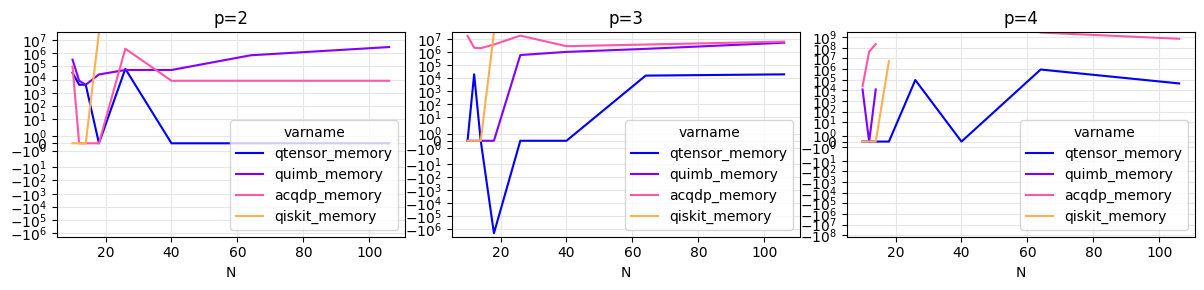

In [71]:
xar_tr = xar.transpose('p', 'varname', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr.sel(
    varname=['qtensor_memory', 'quimb_memory', 'acqdp_memory', 'qiskit_memory']
))

for ax in fig.axes:
    ax.set_yscale('symlog')

In [19]:
    #export
def plot_xar_data(xar_orig):
    xar = xar_orig.transpose('p', 'varname', 'N')
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log', base=2)
    fig = ex.plot_xarray(xar, plot_func=custom_plot)

    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)
    ps = [x.data for x in xar.coords['p']]


    [ax.autoscale() for ax in axes]
    [ax.set_ylabel('Time, sec') for ax in axes]
    [ax.set_title(x) for ax, x in zip(axes, [f"p = {p}" for p in ps])]
    fig.suptitle('Time for single energy query on a single Skylake node', fontfamily='serif', style='italic')
    fig.set_size_inches(10.5, 4.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])


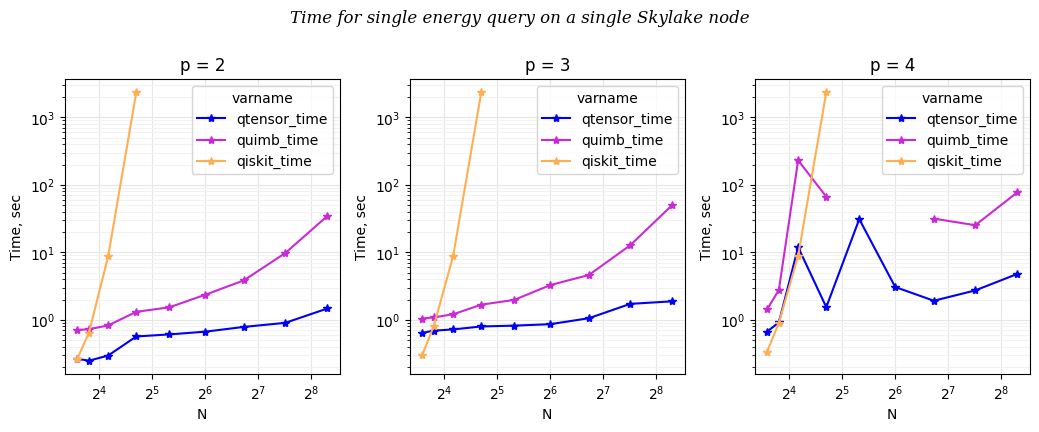

In [21]:
plot_xar_data(xar)

In [20]:
def plot_xar_data_simple(xar_orig):
    xar = xar_orig.sel(p=3)
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log' )
        plt.xticks([10, 20, 50, 100, 200, 500])
    fig = ex.plot_xarray(xar, plot_func=custom_plot)
    from matplotlib.ticker import FormatStrFormatter

    fig.gca().xaxis.set_major_formatter(FormatStrFormatter('%.i'))
    fig.gca().yaxis.set_major_formatter(FormatStrFormatter('%.i'))


    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)


    fig.gca().set_ylabel('Time, sec')
    fig.gca().set_xlabel('Number of qubits')
    fig.suptitle('Time for a quantum circuit simulation', fontfamily='serif', style='italic')
    plt.legend(['Our simulator', 'Caltech simulator', 'IBM simulator'])
    fig.set_size_inches(5., 4.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])

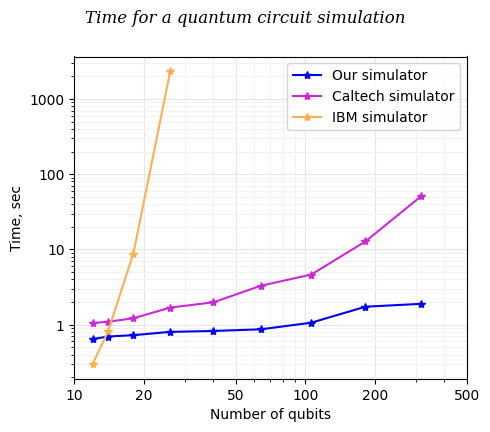

In [32]:
plot_xar_data_simple(xar)
plt.savefig('../../../data/figures/speed_comparison_simple_p3.png')
plt.savefig('../../../data/figures/speed_comparison_simple_p3.pdf')

## CLI

In [49]:
#export
from qtensor_specs import cli, click

In [50]:
#export
@cli.command()
@click.option('--n_len', default=4)
@click.option('--p_len', default=2)
@click.option('-O', '--qtn_ordering_algo', default='greedy')
@click.option('-N', '--n_processes', default=2)
@click.argument('filename')
def time_comparison_xarray(filename, n_len, p_len, **kwargs):
    Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10
    Ns = Ns[:n_len]
    ps = [2, 3, 4]
    ps = ps[:p_len]
    kwargs = {k:[v] for k, v in kwargs.items()}
    xar = gen_time_data(Ns, ps, **kwargs)
    xar.to_netcdf(filename)
    

In [62]:
#export
import logging
ql = logging.getLogger('qiskit')
ql.setLevel(logging.ERROR)

In [64]:
Ns = [10, 14]
ps = [2, 3]
xar = gen_time_data(Ns, ps)



_dimcount 3


In [65]:
#hide
#default_exp speed_comparison

from nbdev.export  import *
notebook2script()

Converted QAOA_bench.ipynb.
Converted Speed_comparison.ipynb.
Converted Time_vs_FLOP.ipynb.
Converted index.ipynb.
